In [1]:
using Graphs
using Plots
using LinearAlgebra
include("../inference/zero_patient.jl")
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [2]:
q = q_sis
T = 5
N = 20
k = 3
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.1
κ = 0.08
p⁰ = map(1:N) do i
    p_infected = 3/N
    [1-p_infected, p_infected]
end
sis = SIS(g, λ, κ, T; p⁰);

In [3]:
function sis_compare_bp_mc(T::Integer, N::Integer, λ::Real, κ::Real, γ::Real,
        nobs::Integer; softinf=1e2, nsamples_mc=10^5)
    
    gg = random_regular_graph(N, 3)
    g = IndexedGraph(gg)
    p⁰ = fill([1-γ, γ], N)
    sis = SIS(g, λ, κ, T; p⁰)
    X, bp = simulate_sis(g, λ, κ, p⁰, T, nobs; softinf)
    true_zp = findall(isequal(I), X[:,1]) 
    id_bp, b⁰_bp = find_zero_patients_bp(bp)
    id_mc, b⁰_mc, sms = find_zero_patients_mc(bp; nsamples=nsamples_mc)
    auc_bp = round(auc(id_bp, true_zp), digits=4)
    auc_mc = round(auc(id_mc, true_zp), digits=4)
    
    return auc_bp, auc_mc
end

sis_compare_bp_mc (generic function with 1 method)

In [4]:
nobs = 100
softinf = 1e2
X, bp = simulate_sis(g, λ, κ, p⁰, T, nobs; softinf);

In [5]:
true_zp = findall(isequal(I), X[:,1]) 

1-element Vector{Int64}:
 6

In [6]:
@time begin
    id_bp, b⁰_bp = find_zero_patients_bp(bp)
end
b_bp = beliefs(bp)
[id_bp b⁰_bp][1:10,:]

Running MPdBP: iter 7 	 Time: 0:00:31
  Δ:  0.0004208003183213682

 40.652179 seconds (57.88 M allocations: 3.915 GiB, 9.22% gc time, 84.47% compilation time)


10×2 Matrix{Float64}:
  1.0  0.539696
  6.0  0.351053
 13.0  0.351053
 20.0  0.0665226
 14.0  0.0572368
 12.0  0.0572341
 10.0  0.0572336
  2.0  0.057231
  3.0  0.0324404
  4.0  0.032382

In [7]:
nsamples = 10^5
@time begin
    id_mc, b⁰_mc, sms = find_zero_patients_mc(bp; nsamples)
end
b_mc = marginals(sms)
[id_mc [b.val for b in b⁰_mc]][1:10,:]

SoftMargin sampling... 100%|█████████████████████████████| Time: 0:00:08


 11.741576 seconds (65.05 M allocations: 3.292 GiB, 13.01% gc time, 21.83% compilation time)


10×2 Matrix{Float64}:
  1.0  0.530782
 13.0  0.383197
  6.0  0.364784
 20.0  0.0887081
 14.0  0.0776436
 12.0  0.076727
 15.0  0.0749068
  7.0  0.0576142
 10.0  0.0406567
  9.0  0.0393952

SIS on random regular graph N=20, k=3. P(S→I)=0.1, P(I→S)=0.08.


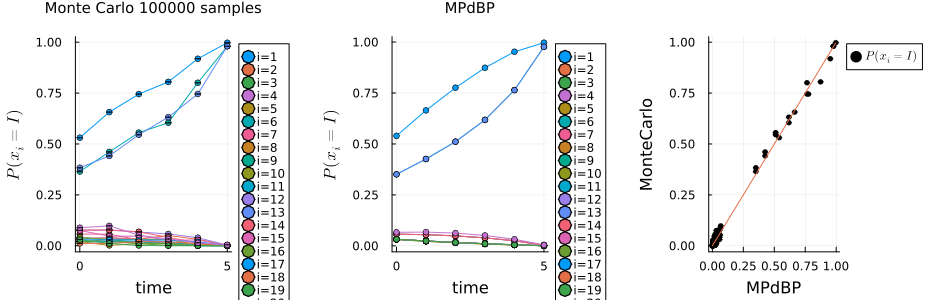

In [8]:
p_bp = [[bbb[2] for bbb in bb] for bb in b_bp]
p_mc = [[bbb[2] for bbb in bb] for bb in b_mc]
pl_mc = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:5:T, title="Monte Carlo $nsamples samples")
for i in 1:N
    plot!(pl_mc, 0:T, p_mc[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:5:T, title="MPdBP")
for i in 1:N
    plot!(pl_bp, 0:T, p_bp[i], label="i=$i", m=:o, ms=3, lw=1)
end
pl_sc = scatter(reduce(vcat, p_bp), reduce(vcat, p_mc), xlabel="MPdBP", ylabel="MonteCarlo", 
    label="\$P(x_i=I)\$", ms=3, c=:black, legend=:outertopright)
plot!(identity, label="", size=(300,300))
println("SIS on random regular graph N=$N, k=$k. P(S→I)=$λ, P(I→S)=$κ.")
# println("$nobs_node random node observations, $nobs_edge random edge observations")
# println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
plot(pl_mc, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright, 
    margin=5Plots.mm, layout=(1,3))

In [9]:
auc_bp = round(auc(id_bp, true_zp), digits=4)
auc_mc = round(auc(id_mc, true_zp), digits=4);

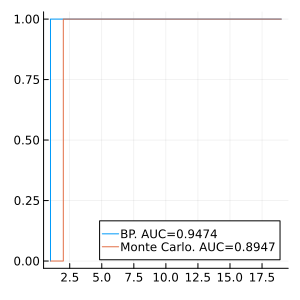

In [10]:
pl_roc = plot(roc(id_bp, true_zp)..., st=:steppre, label="BP. AUC=$auc_bp")
plot!(pl_roc, roc(id_mc, true_zp)..., st=:steppre, label="Monte Carlo. AUC=$auc_mc")
plot(pl_roc, size=(300,300), legend=:bottomright)

In [11]:
T = 5
N = 20
k = 3
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.1
κ = 0.08
γ = 3/N;

In [12]:
ProgressMeter.ijulia_behavior(:append)
nobss = [2, 5, 10]
aucs_bp = [zeros(0) for _ in nobss]
aucs_mc = [zeros(0) for _ in nobss];

In [ ]:
ninstances = 30
for (i, nobs) in enumerate(nobss)
    println("### $nobs observations ###")
    for a in 1:ninstances
        ab, am = sis_compare_bp_mc(T, N, λ, κ, γ, nobs)
        push!(aucs_bp[i], ab)
        push!(aucs_mc[i], am)
    end
end

### 2 observations ###


Running MPdBP: iter 2 	 Time: 0:00:00
Running MPdBP: iter 3 	 Time: 0:00:01
Running MPdBP: iter 4 	 Time: 0:00:02
Running MPdBP: iter 5 	 Time: 0:00:03
Running MPdBP: iter 6 	 Time: 0:00:04
Running MPdBP: iter 7 	 Time: 0:00:05
Running MPdBP: iter 8 	 Time: 0:00:06
Running MPdBP: iter 9 	 Time: 0:00:07
SoftMargin sampling... 100%|█████████████████████████████| Time: 0:00:07
Running MPdBP: iter 2 	 Time: 0:00:00
Running MPdBP: iter 3 	 Time: 0:00:01
Running MPdBP: iter 4 	 Time: 0:00:02
Running MPdBP: iter 5 	 Time: 0:00:03
Running MPdBP: iter 6 	 Time: 0:00:04
Running MPdBP: iter 7 	 Time: 0:00:05
Running MPdBP: iter 8 	 Time: 0:00:05
SoftMargin sampling... 100%|█████████████████████████████| Time: 0:00:08
Running MPdBP: iter 2 	 Time: 0:00:00
Running MPdBP: iter 3 	 Time: 0:00:01
Running MPdBP: iter 4 	 Time: 0:00:02
Running MPdBP: iter 5 	 Time: 0:00:03
Running MPdBP: iter 6 	 Time: 0:00:04
Running MPdBP: iter 7 	 Time: 0:00:05
SoftMargin sampling... 100%|████████████████████████████

In [ ]:
aucs_bp_avg = mean.(aucs_bp)
aucs_bp_std = std.(aucs_bp) ./ sqrt(ninstances)
aucs_mc_avg = mean.(aucs_mc)
aucs_mc_std = std.(aucs_mc) ./ sqrt(ninstances)
println("SIS with: P(S→I)=λ=$λ, P(I→S)=κ=$κ. P(zero patient)=γ=$γ")
println("Random regular N=$N, k=3. T=$T, random observations from the prior")
plot(nobss, aucs_bp_avg, m=:o, ribbon=aucs_bp_std, label="bp", legend=:bottomright)
plot!(nobss, aucs_mc_avg, m=:o, ribbon=aucs_mc_std, label="mc", xlabel="number of obs", ylabel="AUC")

In [219]:
savefig("zeropatient.pdf")